In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import math
import random
import glob
from tqdm import tqdm

from fastai import vision, basic_data, layers, metrics

## Data retrieval

In [3]:
path = vision.Path('data')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('data')

In [8]:
import sys
!{sys.executable} -m pip install kaggle

     |████████████████████████████████| 61kB 5.2MB/s eta 0:00:011
     |████████████████████████████████| 81kB 12.8MB/s eta 0:00:01
  Stored in directory: /home/jupyter/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
  Stored in directory: /home/jupyter/.cache/pip/wheels/24/23/f5/c260686f9180cd755a30123e607207e0f39eba249b7b4b432c
Successfully built kaggle python-slugify


### Train data

In [10]:
# Download the zip archive with images for training
!kaggle competitions download -c airbus-ship-detection -f train_v2.zip -p {path}

100%|██████████████████████████████████████▉| 26.4G/26.4G [04:15<00:00, 252MB/s]
100%|███████████████████████████████████████| 26.4G/26.4G [04:15<00:00, 111MB/s]


In [11]:
# Unzip the archive
!unzip -q -n {path}/train_v2.zip -d {path}/train_v2
!rm {path}/train_v2.zip

In [12]:
# Download the segmentations file archive
!kaggle competitions download -c airbus-ship-detection -f train_ship_segmentations_v2.csv -p {path}

 67%|██████████████████████████             | 12.0M/18.0M [00:00<00:00, 125MB/s]
100%|███████████████████████████████████████| 18.0M/18.0M [00:00<00:00, 155MB/s]


In [13]:
# Unzip the archive
!unzip -q -o {path}/train_ship_segmentations_v2.csv.zip -d {path}
!rm {path}/train_ship_segmentations_v2.csv.zip

In [14]:
# Grant read permissions
!chmod 644 {path}/train_ship_segmentations_v2.csv

### Test data

In [15]:
# Download the zip archive with images for testing
!kaggle competitions download -c airbus-ship-detection -f test_v2.zip -p {path}

100%|██████████████████████████████████████▊| 2.11G/2.12G [00:11<00:00, 134MB/s]
100%|███████████████████████████████████████| 2.12G/2.12G [00:12<00:00, 190MB/s]


In [16]:
# Unzip the archive
!unzip -q -n {path}/test_v2.zip -d {path}/test_v2
!rm {path}/test_v2.zip

In [17]:
# Download the sample submission file
!kaggle competitions download -c airbus-ship-detection -f sample_submission_v2.csv -p {path}

  0%|                                                | 0.00/274k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 274k/274k [00:00<00:00, 72.6MB/s]


In [18]:
path.ls()

[PosixPath('data/test_v2'),
 PosixPath('data/train_ship_segmentations_v2.csv'),
 PosixPath('data/sample_submission_v2.csv'),
 PosixPath('data/train_v2')]

## Data exploration

In [4]:
masks_df = pd.read_csv(path/'train_ship_segmentations_v2.csv')

print(masks_df.shape)
masks_df.sample(5)

(231723, 2)


,ImageId,EncodedPixels
212424,eadb974dd.jpg,1698 2 2466 4 3233 7 4001 10 4768 13 5536 15 6...
65337,484d10506.jpg,539373 2 540141 6 540908 10 541676 14 542444 1...
107138,75ed4fcfd.jpg,NaN
201931,df36a66aa.jpg,255647 10 256415 10 257183 10 257951 10 258718...
51178,38dabe454.jpg,NaN


In [5]:
# Convert filename into path
masks_df['ImageId'] = masks_df['ImageId'].map(lambda x: str(path/'train_v2'/x))

In [6]:
# ImageId has duplicates, since each row corresponds to a ship rather than image
len(masks_df['ImageId'].unique()) / len(masks_df.index)

0.8309749140137147

In [7]:
# Retrieve the number of ships and file size
imgs_df = masks_df.copy()
imgs_df['ships'] = imgs_df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
imgs_df = imgs_df.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
imgs_df['file_size_kb'] = imgs_df['ImageId'].map(lambda img_id: os.stat(img_id).st_size/1024)
imgs_df.set_index('ImageId', inplace=True)

print(imgs_df.shape)
imgs_df.sample(5)

(192556, 2)


,ships,file_size_kb
ImageId,,
data/train_v2/38b297ba4.jpg,0,93.623047
data/train_v2/c9729b600.jpg,0,160.905273
data/train_v2/e41979bd4.jpg,0,199.688477
data/train_v2/68b8db212.jpg,0,221.619141
data/train_v2/367f7c12a.jpg,0,109.873047


In [8]:
# Check that images in folder and images in CSV match
img_paths = glob.glob(str(path/'train_v2'/'*.jpg'))
           
assert(len(set(img_paths).intersection(set(imgs_df.index))) == len(img_paths))

In [30]:
# Distribution of the ships count
print(imgs_df['ships'].value_counts().sort_index())

0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
13        75
14        76
15        66
Name: ships, dtype: int64


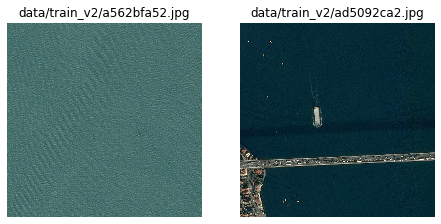

In [10]:
def plot_imgs(img_paths):
    """Plot images."""
    nrows = math.ceil(len(img_paths) / 4)
    f = plt.figure(figsize=(16, 4 * nrows))
    f.tight_layout()
    
    for i, fpath in enumerate(img_paths):
        img = Image.open(fpath)
        sp = f.add_subplot(nrows, 4, i+1)
        sp.axis('off')
        sp.set_title(fpath)
        plt.imshow(img)
        
# Images with the minimum and maximum number of ships
_min, _max = imgs_df['ships'].min(), imgs_df['ships'].max()
fpath_min = imgs_df[imgs_df['ships'] == _min].sample().index[0]
fpath_max = imgs_df[imgs_df['ships'] == _max].sample().index[0]

plot_imgs([fpath_min, fpath_max])

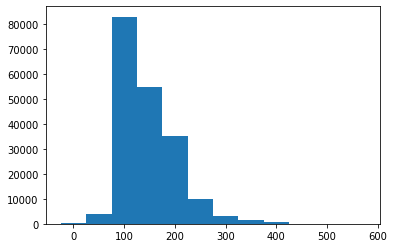

In [26]:
def plot_hist(data, step):
    """Plot the histogram of data."""
    left_of_first_bin = -float(step)/2
    right_of_last_bin = data.max() - data.max() % step + step
    plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + step, step))
    plt.show()
    
plot_hist(imgs_df['file_size_kb'], 50)

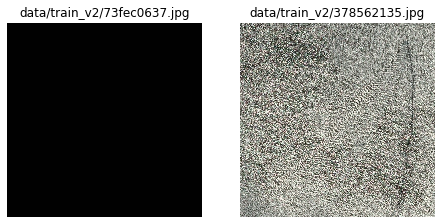

In [27]:
# Images with the minimum and maximum resolution
_min, _max = imgs_df['file_size_kb'].min(), imgs_df['file_size_kb'].max()
fpath_min = imgs_df[imgs_df['file_size_kb'] == _min].sample().index[0]
fpath_max = imgs_df[imgs_df['file_size_kb'] == _max].sample().index[0]

plot_imgs([fpath_min, fpath_max])

## Data cleaning

In [10]:
# Keep images with the size between 100 and 300 KB
imgs_df['clean'] = True
imgs_df.loc[(imgs_df['file_size_kb'] < 100) | (imgs_df['file_size_kb'] > 300), 'clean'] = False

print(len(imgs_df[imgs_df['clean']].index))

162097


In [11]:
# Find corrupted images and masks
from tqdm import tqdm

def find_corrupted():
    """For each image, try to open it and to decode it. Takes some time..."""
    corrupted = []
    img_ids = imgid_df[imgid_df['clean']].index
    for i in tqdm(range(len(img_ids))):
        img_id = img_ids[i]
        try:
            # Test image
            Image.open(path/'train_v2'/img_id)
            # Test masks
            if imgid_df.loc[img_id, 'ships'] > 0:
                masks = masks_df[masks_df['ImageId'] == img_id]['EncodedPixels']
                for mask in masks:
                    if isinstance(mask, str):
                        vision.rle_decode(mask, (768, 768))
        except:
            corrupted.append(img_id)
    return corrupted
        
#find_corrupted()

In [12]:
# Filter out dirty images to reclaim disk space
exclude_set = {'6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
               '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
               'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
               'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg', 'e27eda89e.jpg', 
               '3c1ed3950.jpg'}

imgs_df.loc[imgs_df.index.isin(exclude_set), 'clean'] = False

print(len(imgs_df[imgs_df['clean']].index))

162097


In [13]:
# Filter masks
clean_imgs = set(imgs_df[imgs_df['clean']].index)

print(len(clean_imgs))

162097


## Image segmentation

### Run-length encoding/decoding

In [14]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
from skimage.morphology import label

img_shape = (768, 768)

def rle_encode(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def multi_rle_encode(img):
    """Encodes the image and returns a list of run lengths (one for a ship)."""
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_decode(mask_rle):
    '''
    mask_rle: run-length as string formated (start length)
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(img_shape[0]*img_shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(img_shape).T  # Needed to align to RLE direction

def multi_rle_decode(masks):
    """Decodes each run length into a mask and overlays them."""
    mask_img = np.zeros(img_shape, dtype=np.uint8)
    for mask in masks:
        if isinstance(mask, str):
            mask_img += rle_decode(mask)
    return np.expand_dims(mask_img, -1)

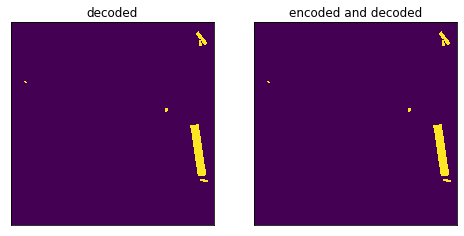

In [16]:
def check_encode_decode(ImageId):
    """Check that encode/decode works."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
    
    rle_0 = masks_df[masks_df['ImageId'] == ImageId]['EncodedPixels']
    img_0 = multi_rle_decode(rle_0)
    ax1.imshow(img_0[:, :, 0])
    ax1.set_title('decoded')
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    rle_1 = multi_rle_encode(img_0)
    img_1 = multi_rle_decode(rle_1)
    ax2.imshow(img_0[:, :, 0])
    ax2.set_title('encoded and decoded')
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    plt.show()
    
check_encode_decode('data/train_v2/92ff29888.jpg')

### Setting up data loaders

In [15]:
def mask_image_to_segment(mask_img):
    """Convert mask image into a fastai.vision.ImageSegment."""
    mask_tensor = basic_data.FloatTensor(mask_img)
    mask_tensor = mask_tensor.view(img_shape[1], img_shape[0], -1)
    return vision.ImageSegment(mask_tensor.permute(2,0,1))

def open_mask(fn):
    """Decode the run length and convert into fastai format."""
    masks = masks_df[masks_df['ImageId'] == str(fn)]['EncodedPixels']
    mask_img = multi_rle_decode(masks)
    mask_img = mask_image_to_segment(mask_img)
    return mask_img

class SegmentationLabelList(vision.ImageList):
    """Our labels are created from encodings in masks_df, no disk I/O operations required."""
    _processor=vision.data.SegmentationProcessor
    def __init__(self, items:basic_data.Iterator, classes:basic_data.Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.copy_new.append('classes')
        self.classes, self.loss_func = classes, layers.CrossEntropyFlat(axis=1)

    def open(self, fn): return open_mask(fn)
    def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
    def reconstruct(self, t:basic_data.Tensor): return vision.ImageSegment(t)

class SegmentationItemList(vision.ImageList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls, _square_show_res = SegmentationLabelList, False

In [16]:
def get_data(bs=16, img_size=(256, 256)):
    """Use the fastai's amazing data block API to construct data loaders."""
    # Do not augment since we have a large dataset anyway, only resize
    tfms = ([vision.transform.crop_pad()], [vision.transform.crop_pad()])
    
    # Segmentation task only on images with ships
    imgs_with_ships = set(imgs_df.loc[imgs_df['ships'] > 0].index)
    # Consider only clean images in train and all in test
    filter_func = lambda x: (str(x) in clean_imgs and str(x) in imgs_with_ships) or x.parents[0] == path/'test_v2'
    
    # Build DataBunch
    return (SegmentationItemList.from_folder(path/'train_v2')
            .filter_by_func(filter_func)
            .split_by_rand_pct(0.2)
            .label_from_func(lambda x: x, classes=[0, 1])
            .transform(tfms, size=img_size, tfm_y=True)
            .add_test((path/'test_v2').ls(), tfm_y=False)
            .databunch(path=path, bs=bs)
            .normalize(vision.imagenet_stats))

data = get_data(bs=28)
data

ImageDataBunch;

Train: LabelList (26630 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/train_v2;

Valid: LabelList (6657 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/train_v2;

Test: LabelList (15606 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: data/train_v2

11578
(256, 256, 3)


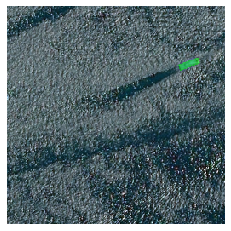

In [17]:
import cv2

def mask_overlay(image, mask, color=(0, 1, 0)):
    """Overlay image with mask."""
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(image.dtype)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, np.argmax(color)] > 0
    img[ind] = weighted_sum[ind]    
    return img

def imshow_random():
    """Take a random image from the dataset and overlay it with the corresponding mask.
    Do this to make sure the fastai transformations work properly."""
    idx = random.choice(range(len(data.train_ds)))
    print(idx)
        
    img = data.train_ds[idx][0]
    img = img.data.permute(1, 2, 0).numpy()
    mask_img = data.train_ds[idx][1]
    mask_img = mask_img.data.permute(1, 2, 0).numpy()
    overlayed = mask_overlay(img, mask_img)
    print(overlayed.shape)
    
    plt.imshow(overlayed)
    plt.axis('off')
    plt.show()
    
imshow_random()

### Loss function and evaluation metrics

In [18]:
def get_label_dist(num_samples=100):
    """Calculate the relative number of pixels corresponding to each label."""
    num_imgs = len(data.train_ds)
    counts = np.zeros((num_imgs, data.c))
    random_idxs = random.sample(range(num_imgs), num_samples)
    
    for idx in random_idxs:
        mask_tensor = data.train_ds[idx][1].data
        for c in range(data.c):
            counts[idx, c] = (mask_tensor == c).sum()
    
    return counts.sum(axis=0)/counts.sum()
    
get_label_dist()

array([0.993565, 0.006435])

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# https://www.kaggle.com/iafoss/unet34-dice-0-87
# https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c
def cuda(x): 
    return x.cuda() if torch.cuda.is_available() else x

def make_one_hot(labels, c=2):
    one_hot = cuda(torch.FloatTensor(labels.size(0), c, labels.size(2), labels.size(3)).zero_())
    target = one_hot.scatter_(1, labels.data, 1)
    target = cuda(Variable(target))
    return target

def dice_loss(input, target):
    """Soft dice loss function.
    https://github.com/pytorch/pytorch/issues/1249"""
    # Input is of shape N,C,H,W
    smooth = 1
    batch_size = input.size(0)
    input = F.softmax(input, dim=1)
    # Since we have only 2 classes transform it to N,H,W and treat as sigmoid
    input = input.view(batch_size, 2, -1)[:, 1, :]
    target = make_one_hot(target).view(batch_size, 2, -1)[:, 1, :]

    inter = torch.sum(input * target) + smooth
    union = torch.sum(input) + torch.sum(target) + smooth

    return -torch.log(2.0 * inter / union)

class FocalLoss(nn.Module):
    """Focal loss function."""
    def __init__(self, gamma):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, input, target):
        # One-hot encode target
        target = target.squeeze(1)
    
        input = input.view(input.size(0),input.size(1),-1) # N,C,H,W => N,C,H*W
        input = input.transpose(1,2)                       # N,C,H*W => N,H*W,C
        input = input.contiguous().view(-1,input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        loss = -1 * (1-pt)**self.gamma * logpt
        return loss.mean()
    
class MixedLoss(nn.Module):
    """Combine two losses and bring them to similar scale."""
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        return self.alpha * self.focal(input, target) + dice_loss(input, target)

loss_func = MixedLoss(10., 2.)

In [20]:
def dice(input, target):
    """Dice metric."""
    input = input.argmax(dim=1).float()
    target = target.squeeze(1).float()
    
    smooth = 1.
    numerator = 2. * (input * target).sum()
    denumerator = (input + target).sum()
    return (numerator + smooth) / (denumerator + smooth)

def IoU(input, target):
    """Intersection over Union (IoU) metric."""
    input = input.argmax(dim=1).float()
    target = target.squeeze(1).float()
    
    smooth = 1.
    intersection = (input * target).sum()
    union = (input + target).sum() - intersection
    return (intersection + smooth) / (union + smooth)

### Model training

In [21]:
def create_unet_learner(data):
    """Create a new U-Net learner."""
    # Select ResNet-34 as encoder and put the whole model in FP16 precision mode
    return vision.unet_learner(data, 
                               vision.models.resnet34, 
                               metrics=[dice, IoU], 
                               loss_func=loss_func, 
                               wd=1e-2).to_fp16()

learn = create_unet_learner(data)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


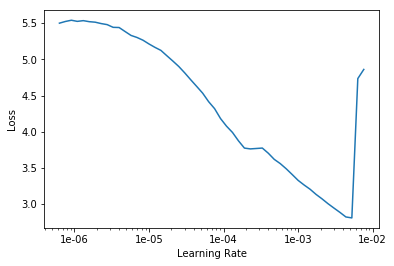

In [29]:
# Launch an LR range test to select an optimal learning rate
learn.lr_find()
learn.recorder.plot()

In [30]:
# Fit a model following the 1-cycle policy
learn.fit_one_cycle(5, slice(1e-03), pct_start=0.9)

epoch,train_loss,valid_loss,dice,IoU
1,0.330177,0.304868,0.804926,0.676646
2,0.271886,0.260295,0.829330,0.710994
3,0.242063,0.238031,0.844326,0.732464
4,0.224682,0.217465,0.856356,0.750792
5,0.150684,0.164680,0.888369,0.800362


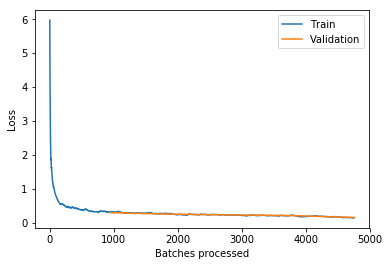

In [31]:
# Plot training vs validation losses
learn.recorder.plot_losses()

In [32]:
# Save the model's artifacts
learn.save('Unet34_256_1')

In [157]:
learn.load('Unet34_256_1');

In [30]:
# Unfreeze the encoder (requires more GPU)
learn.unfreeze()

In [31]:
# Decrease the batch size after unfreezing to fit the data into GPU
learn.data = get_data(bs=24)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


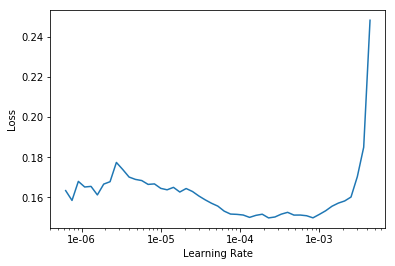

In [32]:
# Do the same as in feature extraction part
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(5, slice(1e-06, 1e-04))

epoch,train_loss,valid_loss,dice,IoU
1,0.137380,0.139075,0.904966,0.827307
2,0.132071,0.131390,0.910007,0.835684
3,0.124420,0.125592,0.913685,0.841809
4,0.113460,0.121133,0.916709,0.846913
5,0.111492,0.120643,0.917260,0.847836


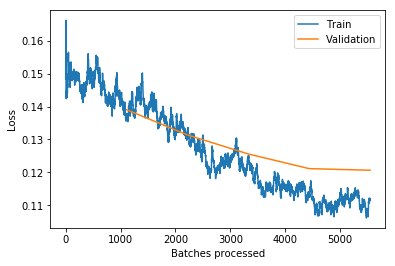

In [34]:
learn.recorder.plot_losses()

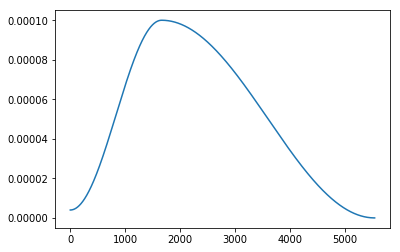

In [35]:
# Illustration of 1-cycle policy
learn.recorder.plot_lr()

In [36]:
learn.save('Unet34_256_2')

In [28]:
# Export the inference learner
learn.export('Unet34_256.pkl')

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type MixedLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Model evaluation

In [22]:
learn.load('Unet34_256_2');

In [42]:
outputs, targets = learn.get_preds(vision.DatasetType.Valid)

In [43]:
def count_true_ships(targets):
    """Get the distribution of true number of ships."""
    ship_counts = []
    for idx, target in enumerate(tqdm(targets)):
        masks = multi_rle_encode(target.permute(1,2,0))
        ship_counts.append(len(masks))
    return np.array(ship_counts)

true_ship_counts = count_true_ships(targets)

100%|██████████| 6657/6657 [00:06<00:00, 1053.44it/s]


In [44]:
def count_pred_ships(outputs):
    """Get the distribution of predicted number of ships."""
    ship_counts = []
    for idx, output in enumerate(tqdm(outputs)):
        probs = F.softmax(output, dim=0)
        mask_tensor = probs.argmax(dim=0)
        mask_tensor = mask_tensor.unsqueeze(2)
        masks = multi_rle_encode(mask_tensor)
        ship_counts.append(len(masks))
    return np.array(ship_counts)

pred_ship_counts = count_pred_ships(outputs)

100%|██████████| 6657/6657 [00:19<00:00, 341.18it/s]


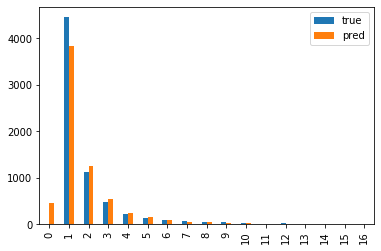

In [45]:
def compare_similar_dists(a, b, column_names):
    """Bar-plot both distributions on the same scale."""
    stacked = np.vstack([a, b]).flatten()
    _min, _max = stacked.min(), stacked.max()
    a_sr = pd.Series(a).value_counts().sort_index()
    b_sr = pd.Series(b).value_counts().sort_index()
    df = pd.DataFrame(0, columns=column_names, index=range(_min, _max+1))
    for i in df.index:
        if i in a_sr.index:
            df.loc[i, column_names[0]] = a_sr.loc[i]
        if i in b_sr.index:
            df.loc[i, column_names[1]] = b_sr.loc[i]
    df.plot.bar()
    
compare_similar_dists(true_ship_counts, pred_ship_counts, ['true', 'pred'])

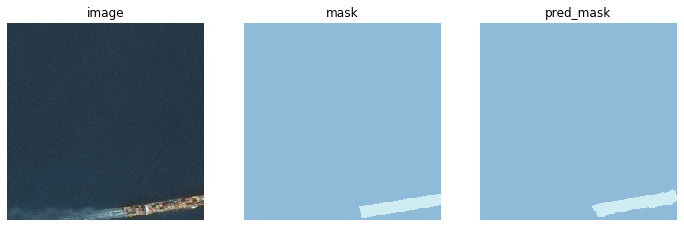

In [47]:
def imshow_valid_random():
    """Take a random image from the validation set and compare its mask to the predicted one."""
    idx = random.choice(range(len(data.valid_ds)))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    img = learn.data.valid_ds[idx][0]
    mask = learn.data.valid_ds[idx][1]
    img.show(ax=ax1)
    ax1.set_title('image')
    mask.show(ax=ax2)
    ax2.set_title('mask')
    learn.predict(learn.data.valid_ds[idx][0])[0].show(ax=ax3)
    ax3.set_title('pred_mask')
    
    plt.axis('off')
    plt.show()
    
imshow_valid_random()

### Model testing

In [22]:
# Do not use learn.get_preds(vision.DatasetType.Test)
# First "OSError: [Errno 12] Cannot allocate memory"
# Second exceeds CPU memory if processing the entire dataset
# Thus create own iterator that encodes each image on the fly without keeping big tensors in memory

In [36]:
def get_test_masks():
    """For each image in the test set, predict its mask and encode it. 
    Operates on target resolution of 768x768. 
    Returns the list of run length encodings."""
    pred_masks = []
    for x, y in tqdm(learn.data.test_ds):
        _, _, output = learn.predict(x)
        # 768/256 = factor of 3
        upsampler = torch.nn.Upsample(scale_factor=3, mode='bilinear', align_corners=False)
        upsampled = upsampler(output.unsqueeze(0)).squeeze(0)
        probs = F.softmax(upsampled, dim=0)
        mask_tensor = probs.argmax(dim=0)
        mask_tensor = mask_tensor.unsqueeze(2)
        masks = multi_rle_encode(mask_tensor)
        pred_masks.append(masks)
    return pred_masks

test_masks = get_test_masks()

100%|██████████| 15606/15606 [29:04<00:00,  8.95it/s]


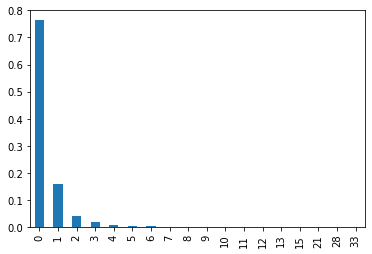

In [37]:
# Plot the distribution of the number of ships in the test set
# Should be consistent
test_ship_counts = list(map(len, test_masks))
pd.Series(test_ship_counts).value_counts(normalize=True).sort_index().plot.bar()

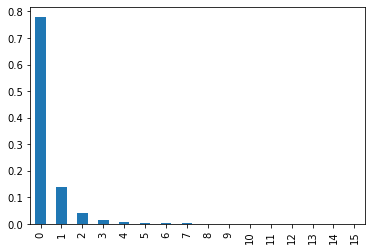

In [32]:
# Compare with the distribution in the train set (should be similar)
imgs_df['ships'].value_counts(normalize=True).sort_index().plot.bar()

In [48]:
# Sample submission file
sample_sub_df = pd.read_csv(path/'sample_submission_v2.csv')
print(sample_sub_df.shape)
sample_sub_df.head()

(15606, 2)


,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


In [74]:
def create_submission_df(test_masks):
    """Create submission dataframe."""
    test_ids = list(map(lambda x: x.name, learn.data.test_dl.dataset.items))
    img_masks = list(zip(test_ids, test_masks))
    flat_img_masks = [] 
    for img, masks in img_masks:
        if len(masks) > 0:
            for mask in masks:
                flat_img_masks.append([img, mask])
        else:
            flat_img_masks.append([img, None])
    df = pd.DataFrame(flat_img_masks, columns=['ImageId', 'EncodedPixels'])
    return df

# Each row represents a single predicted ship segmentation
sub_df = create_submission_df(test_masks)
print(sub_df.shape)
sub_df.head()

(18085, 2)


,ImageId,EncodedPixels
0,1a9b7b4d8.jpg,652 12 1420 12 2188 13 2955 14 3723 15 4491 16...
1,5df42f18d.jpg,None
2,5ecb2cd5c.jpg,None
3,7589f14ff.jpg,None
4,72458aa27.jpg,None


In [68]:
# Check whether our submission df contains all image ids from the sample df
assert(sample_sub_df['ImageId'].isin(set(sub_df['ImageId'].unique())).all())

In [69]:
# Generate submission file
sub_df.to_csv(path/'submission.csv', header=True, index=False)

14269 b03bfeaf2.jpg


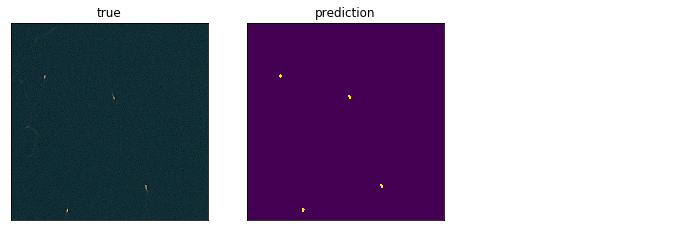

In [169]:
def imshow_test_random(sub_df):
    """Take a random image from the test set and compare masks from multiple submissions."""
    idx = random.choice(range(len(data.test_ds)))
    test_ids = list(map(lambda x: x.name, learn.data.test_dl.dataset.items))
    test_id = test_ids[idx]
    print(idx, test_id)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    img = Image.open(path/'test_v2'/test_id)
    ax1.imshow(img)
    ax1.set_title("true")
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    rle_1 = sub_df[sub_df['ImageId'] == test_id]['EncodedPixels']
    img_1 = multi_rle_decode(rle_1)
    ax2.imshow(img_1[:, :, 0])
    ax2.set_title("prediction")
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    plt.axis('off')
    plt.show()
    
imshow_test_random(sub_df)

## Binary classification

In [151]:
# How balanced is the dataset?
wo_ships_query = imgs_df['clean'] & (imgs_df['ships'] == 0)
w_ships_query = imgs_df['clean'] & (imgs_df['ships'] > 0)
imgs_wo_ships = set(imgs_df[wo_ships_query].index)
imgs_w_ships = set(imgs_df[w_ships_query].index)

len(imgs_wo_ships), len(imgs_w_ships)

(128810, 33287)

In [152]:
# Downsample the images without ships
cl_imgs = set(random.sample(imgs_wo_ships, len(imgs_w_ships))) | imgs_w_ships

# the new train + validation
len(cl_imgs)

66574

In [153]:
def get_cl_data(bs=64, img_size=(256, 256)):
    """Use the fastai's amazing data block API to construct data loaders."""
    tfms = vision.get_transforms(flip_vert=True, max_zoom=1., max_warp=None, max_lighting=None)
    return (vision.ImageList.from_folder(path/'train_v2')
            .filter_by_func(lambda x: str(x) in cl_imgs)
            .split_by_rand_pct(0.2)
            .label_from_func(lambda x: str(x) in imgs_w_ships)
            .transform(tfms, size=img_size)
            .add_test((path/'test_v2').ls(), tfm_y=False)
            .databunch(path=path, bs=bs)
            .normalize(vision.imagenet_stats))

cl_data = get_cl_data()
cl_data

ImageDataBunch;

Train: LabelList (53260 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
True,True,True,True,True
Path: data/train_v2;

Valid: LabelList (13314 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
False,True,True,True,True
Path: data/train_v2;

Test: LabelList (15606 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: data/train_v2

In [154]:
def create_cnn_learner(data):
    """Create a new CNN learner."""
    return vision.cnn_learner(data, vision.models.resnet34, metrics=metrics.accuracy)

cl_learn = create_cnn_learner(cl_data)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


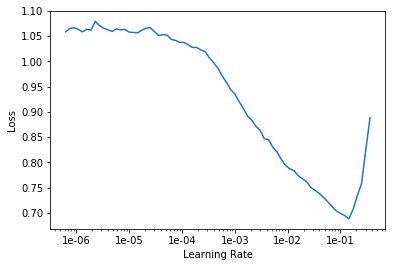

In [24]:
# The same approach as for segmentation task
cl_learn.lr_find()
cl_learn.recorder.plot()

In [25]:
cl_learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,accuracy
1,0.237676,0.139811,0.946598
2,0.192989,0.126411,0.952606
3,0.157286,0.111658,0.959066
4,0.130949,0.087380,0.968229
5,0.130832,0.089485,0.967027


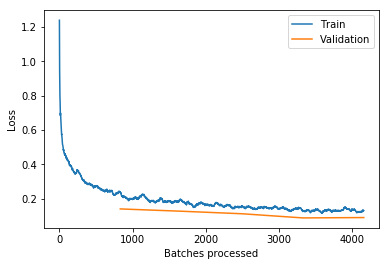

In [31]:
cl_learn.recorder.plot_losses()

In [34]:
cl_learn.save('Resnet34_256_1')

In [24]:
cl_learn.load('Resnet34_256_1');

In [25]:
cl_learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


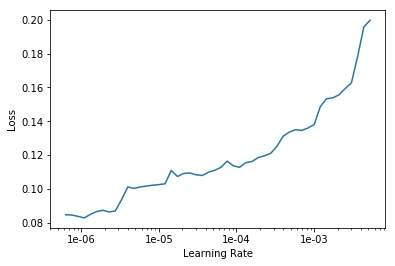

In [26]:
cl_learn.lr_find()
cl_learn.recorder.plot()

In [27]:
cl_learn.fit_one_cycle(10, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.115520,0.087944,0.969731
2,0.113862,0.081118,0.970407
3,0.094870,0.075243,0.973336
4,0.097015,0.073903,0.974538
5,0.083740,0.065513,0.977017
6,0.076560,0.063514,0.978068
7,0.072485,0.063701,0.977993
8,0.069260,0.060580,0.979120
9,0.076709,0.058557,0.978669
10,0.065059,0.057908,0.979345


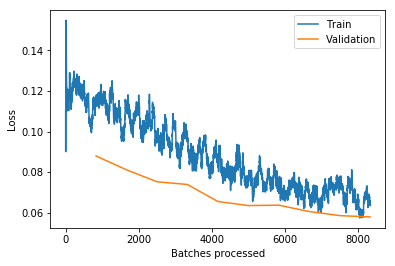

In [28]:
cl_learn.recorder.plot_losses()

In [29]:
cl_learn.save('Resnet34_256_2')

### Model evaluation

In [156]:
cl_learn.load('Resnet34_256_2');

In [171]:
cl_outputs, cl_targets = cl_learn.get_preds(vision.DatasetType.Valid)

In [195]:
# Calculate predictions
cl_valid_true = cl_targets.cpu().numpy()
cl_valid_prob = cl_outputs.cpu().numpy()[:, 1]
cl_valid_pred = cl_outputs.argmax(dim=1).cpu().numpy()

In [181]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion_matrix(cl_valid_true, cl_valid_pred)

array([[6476,  171],
       [  61, 6606]])

True: 0
Predicted: 0.99989283


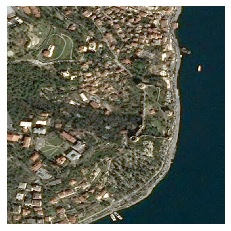

In [208]:
def imshow_misclassified(cl_valid_true, cl_valid_prob, i):
    """Show misclassified images.
    i: 0-most misclassified, 1-least misclassified"""
    sort_idxs = np.argsort(np.abs(cl_valid_true-cl_valid_prob))[::-1]
    idx = sort_idxs[i]
    print("True:", cl_valid_true[idx])
    print("Predicted:", cl_valid_prob[idx])
    img = Image.open(learn.data.valid_dl.dataset.items[idx])
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
imshow_misclassified(cl_valid_true, cl_valid_prob, 0)

In [210]:
cl_outputs, cl_targets = cl_learn.get_preds(vision.DatasetType.Test)

In [219]:
cl_test_pred = cl_outputs.argmax(dim=1).cpu().numpy()
cl_test_pred_dict = dict(list(zip(map(lambda x: x.name, learn.data.test_dl.dataset.items), cl_test_pred)))

In [223]:
sub_corr_df = pd.read_csv(path/'submission.csv')

In [224]:
sub_corr_df['EncodedPixels'].isnull().sum()

12689

In [226]:
# For images that have ships according to U-Net but do not have according to ResNet, remove ships
for i, row in sub_corr_df.iterrows():
    if cl_test_pred_dict[row['ImageId']] == 0:
        row['EncodedPixels'] = None

In [227]:
sub_corr_df['EncodedPixels'].isnull().sum()

12810

In [228]:
# Generate new submission file
sub_corr_df.to_csv(path/'submission_corrected.csv', header=True, index=False)

In [62]:
# Export the inference learner
cl_learn.export('Resnet34_256.pkl')

In [210]:
# Other resources:
# https://towardsdatascience.com/image-segmentation-kaggle-experience-9a41cb8924f0
# https://github.com/kheyer/ML-DL-Projects/tree/master/Airbus%20Ship%20Detection